In [64]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [4]:
df = pd.read_csv("spotify_churn_dataset.csv")

In [5]:
df.head()

,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,1,Female,54,CA,Free,26,23,0.20,Desktop,31,0,1
1,2,Other,33,DE,Family,141,62,0.34,Web,0,1,0
2,3,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,1
3,4,Female,22,CA,Student,36,2,0.31,Mobile,0,1,0
4,5,Other,29,US,Family,250,57,0.36,Mobile,0,1,1


## EDA

In [8]:
df.isna().sum()

user_id                  0
gender                   0
age                      0
country                  0
subscription_type        0
listening_time           0
songs_played_per_day     0
skip_rate                0
device_type              0
ads_listened_per_week    0
offline_listening        0
is_churned               0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [10]:
df.describe()

,user_id,age,listening_time,songs_played_per_day,skip_rate,ads_listened_per_week,offline_listening,is_churned
count,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,4000.50000,37.662125,154.068250,50.127250,0.300127,6.943875,0.747750,0.258875
std,2309.54541,12.740359,84.015596,28.449762,0.173594,13.617953,0.434331,0.438044
min,1.00000,16.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2000.75000,26.000000,81.000000,25.000000,0.150000,0.000000,0.000000,0.000000
50%,4000.50000,38.000000,154.000000,50.000000,0.300000,0.000000,1.000000,0.000000
75%,6000.25000,49.000000,227.000000,75.000000,0.450000,5.000000,1.000000,1.000000
max,8000.00000,59.000000,299.000000,99.000000,0.600000,49.000000,1.000000,1.000000


In [11]:
df.shape

(8000, 12)

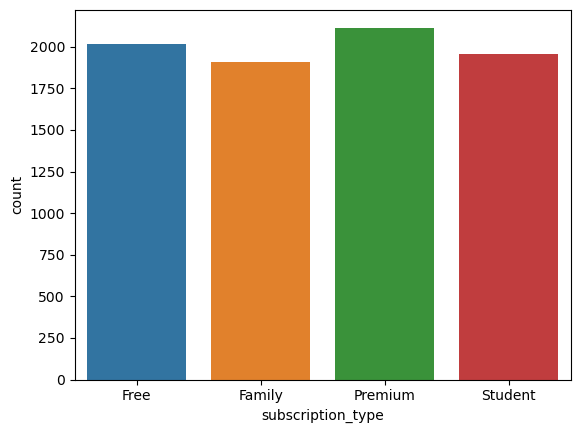

In [ ]:
sns.countplot(data=df, x='subscription_type',hue="subscription_type")
plt.show()

<Axes: xlabel='age', ylabel='Count'>

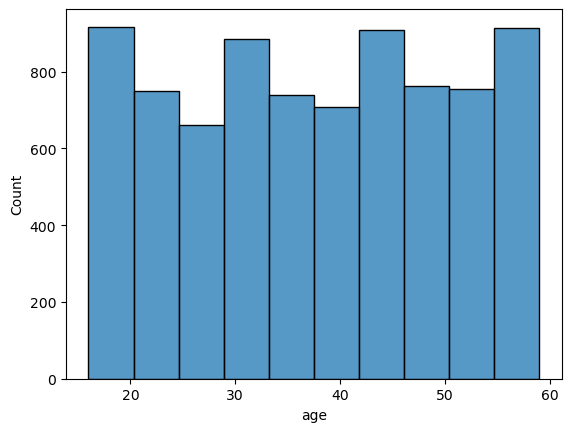

In [45]:
sns.histplot(data=df,x="age",bins=10)

<Axes: xlabel='device_type', ylabel='count'>

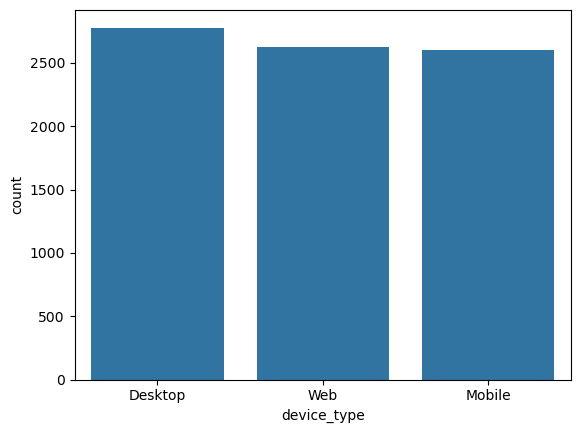

In [37]:
sns.countplot(data=df,x="device_type")

## ML 

In [ ]:
df_SS = StandardScaler

In [54]:
X = df.drop(['is_churned'],axis=1)
y = df['is_churned']

In [56]:
# Identify column types
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object','category']).columns

# Preprocess: one-hot encode categoricals; scale numerics
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    ],
    remainder='drop'
)

# Build pipeline: preprocessing -> KNN
pipe = Pipeline(steps=[
    ('prep', preprocess),
    ('knn', KNeighborsClassifier())
])

In [57]:
X_train , X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [60]:
param_grid = {'knn__n_neighbors': [3,5,7,9,11]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1')
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['user_id', 'age', 'listening_time', 'songs_played_per_day', 'skip_rate',
       'ads_listened_per_week', 'offline_listening'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         Index(['gender', 'country', 'subscription_type', 'device_type'], dtype='object'))])),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1, param_grid={'knn__n_neighbors': [3, 5, 7, 9, 11]},
             scoring='f1')

In [61]:
print("Best k:", grid.best_params_)
best_model = grid.best_estimator_

Best k: {'knn__n_neighbors': 3}


In [ ]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.659375
              precision    recall  f1-score   support

           0       0.75      0.83      0.78      1198
           1       0.24      0.16      0.19       402

    accuracy                           0.66      1600
   macro avg       0.49      0.49      0.49      1600
weighted avg       0.62      0.66      0.64      1600

